In [24]:
import os
try:
    path_initialized
except NameError:
    path_initialized = True
    os.chdir('..')

from swiper.lattice_surgery_schedule import LatticeSurgerySchedule
from swiper.schedule_experiments import MemorySchedule, RegularTSchedule, MSD15To1Schedule, RandomTSchedule
from swiper.device_manager import DeviceManager
from swiper.window_builder import WindowBuilder
from swiper.window_manager import SlidingWindowManager
from swiper.decoder_manager import DecoderManager
from swiper.simulator import DecodingSimulator
import swiper.plot as plotter
import pickle
import json

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [25]:
with open('benchmarks/data/decoding_dists.pkl', 'rb') as f:
    dists = pickle.load(f)

In [26]:
dists_json = {}
for key,vals in dists.items():
    for key2,vals2 in vals.items():
        dists_json.setdefault(key, {})[key2] = vals2.tolist()
with open('benchmarks/data/decoding_dists.json', 'w') as f:
    json.dump(dists_json, f)

In [27]:
def draw_dag(G):
    for layer, nodes in enumerate(nx.topological_generations(G)):
        # `multipartite_layout` expects the layer as a node attribute, so add the
        # numeric layer value as a node attribute
        for node in nodes:
            G.nodes[node]["layer"] = layer

    # Compute the multipartite_layout using the "layer" node attribute
    pos = nx.multipartite_layout(G, subset_key="layer")

    nx.draw_networkx(G, pos=pos)

In [28]:
scheduling_method = 'sliding'

In [29]:
schedule = LatticeSurgerySchedule(True)
schedule.idle([(0,0)], 15)
schedule.inject_T([(1,0)])
idx = schedule.merge([(0,0), (1,0)])
schedule.discard([(1,0)])
schedule.conditional_S((0,0), idx)
schedule.discard([(0,0)])

## RegularTSchedule, not using speculation

Here, speculation time is much longer than decoding time, so we are just doing
standard sliding window.

In [30]:
simulator = DecodingSimulator()
success, sim_params, device_data, window_data, decoding_data = simulator.run(
    schedule=RandomTSchedule(10, 10, 0).schedule,
    distance=7,
    scheduling_method='parallel',
    decoding_latency_fn=lambda x: 0,
    speculation_mode='separate',
    speculation_latency=1,
    speculation_accuracy=0.9,
    max_parallel_processes=None,
    progress_bar=True,
    rng=0,
    lightweight_setting=0,
)

Surface code rounds: 307it [00:00, 15170.97it/s]


In [8]:
device_data.num_rounds

306

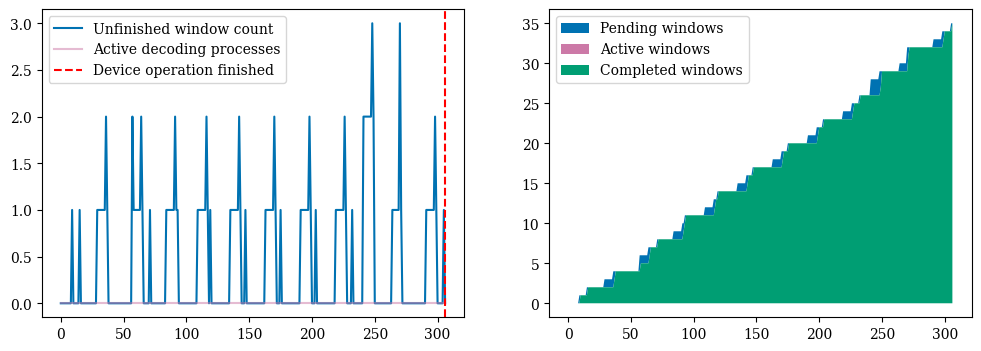

In [9]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

window_count_history = np.zeros((decoding_data.num_rounds), dtype=int)
for round in window_data.window_construction_times.values():
    window_count_history[round:] += 1
ax[0].plot(range(decoding_data.num_rounds), np.array(window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), np.array(decoding_data.completed_windows_by_round)+np.array(decoding_data.parallel_processes_by_round), window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, np.array(decoding_data.completed_windows_by_round) + np.array(decoding_data.parallel_processes_by_round), label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()

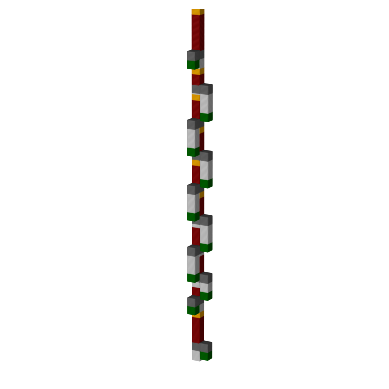

In [10]:
ax = plotter.plot_device_schedule_trace(device_data)
ax.set_axis_off()
plt.savefig('notebooks/figures/random_t.png', bbox_inches='tight', dpi=300)

<Axes3D: >

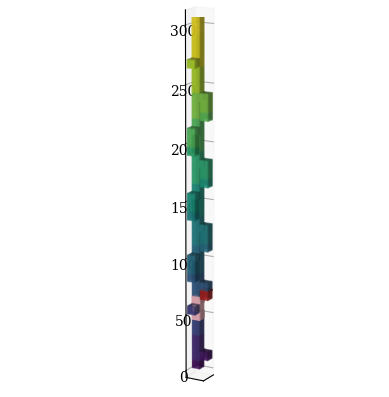

In [11]:
plotter.plot_windows(
    device_data=device_data,
    window_data=window_data,
    decoder_data=decoding_data,
    window_buffers_to_highlight=[7, 6],
    spacing=1,
)

## 15 - 1 Factory

In [12]:
speculation_mode, scheduling_method = 'separate', 'aligned'
# speculation_mode, scheduling_method = None, 'parallel'

In [13]:
simulator = DecodingSimulator()
success, _, device_data, window_data, decoding_data = simulator.run(
    schedule=MSD15To1Schedule().schedule,
    distance=7,
    scheduling_method=scheduling_method,
    decoding_latency_fn=lambda x: 14,
    speculation_mode=speculation_mode,
    speculation_latency=1,
    speculation_accuracy=0.9,
    poison_policy='successors',
    max_parallel_processes=None,
    progress_bar=True,
    rng=0,
    lightweight_setting=0,
)
print(device_data.num_rounds, decoding_data.num_rounds)

Surface code rounds: 94it [00:00, 2186.50it/s]

79 94


In [14]:
len(simulator._window_manager.all_windows)

187

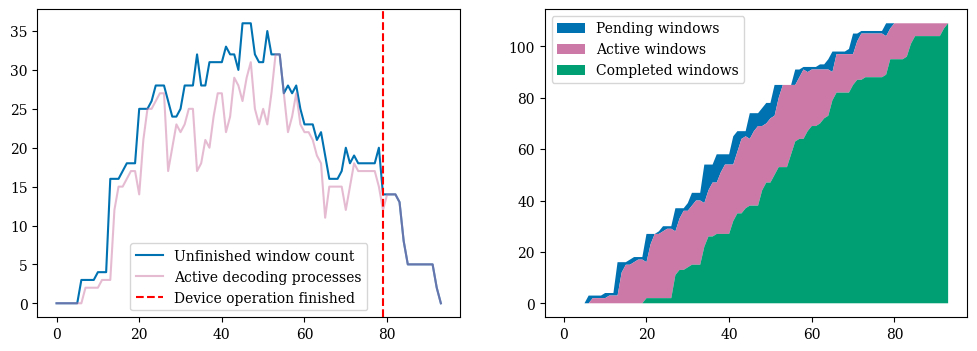

In [15]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

window_count_history = np.zeros((decoding_data.num_rounds), dtype=int)
for round in window_data.window_construction_times.values():
    window_count_history[round:] += 1
ax[0].plot(range(decoding_data.num_rounds), np.array(window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), np.array(decoding_data.completed_windows_by_round)+np.array(decoding_data.parallel_processes_by_round), window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, np.array(decoding_data.completed_windows_by_round) + np.array(decoding_data.parallel_processes_by_round), label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()

79


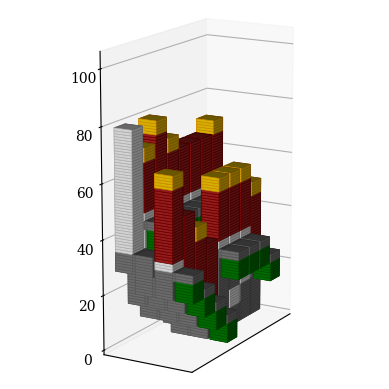

In [16]:
ax = plotter.plot_device_schedule_trace(device_data, spacing=1, z_max=106)
# plt.title(f'{scheduling_method} ({decoding_data.num_rounds} rounds)')
print(device_data.num_rounds)
# ax.set_zlim(0,106)
if speculation_mode:
    plt.savefig(f'notebooks/figures/MSD_{scheduling_method}_spec.png', bbox_inches='tight', dpi=300)
else:
    plt.savefig(f'notebooks/figures/MSD_{scheduling_method}_nospec.png', bbox_inches='tight', dpi=300)

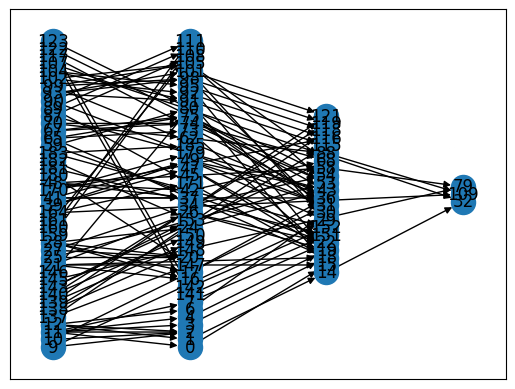

In [17]:
draw_dag(nx.DiGraph(window_data.window_dag_edges))

<Axes3D: >

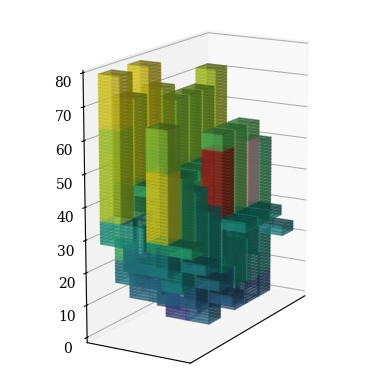

In [18]:
selected_window_idx_1 = -1
for i in window_data.all_constructed_windows:
    window = window_data.get_window(i)
    if selected_window_idx_1 >= 0:
        break
    for cr in window.commit_region:
        if cr.patch == (3,3):
            selected_window_idx_1 = i
            break

selected_window_idx_2 = -1
for i in window_data.all_constructed_windows:
    window = window_data.get_window(i)
    if selected_window_idx_2 >= 0:
        break
    for cr in window.commit_region:
        if cr.patch == (2,7) and cr.duration == 3:
            selected_window_idx_2 = i
            break

plotter.plot_windows(
    device_data=device_data,
    window_data=window_data,
    decoder_data=decoding_data,
    window_buffers_to_highlight=[selected_window_idx_1, selected_window_idx_2],
    spacing=1,
)

In [19]:
simulator = DecodingSimulator()
success, _, device_data, window_data, decoding_data = simulator.run(
    schedule=RegularTSchedule(1, 10).schedule,
    distance=7,
    scheduling_method='sliding',
    decoding_latency_fn=lambda x: 14,
    speculation_mode=None,
    speculation_latency=1,
    speculation_accuracy=0.9,
    max_parallel_processes=None,
    progress_bar=True,
    rng=0,
    lightweight_setting=0,
)

Surface code rounds: 137it [00:00, 11174.81it/s]


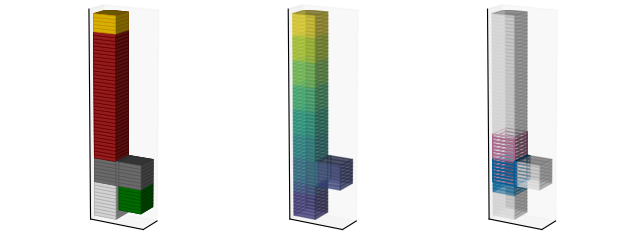

In [20]:
fig = plt.figure(figsize=(8,8))
ax0 = fig.add_subplot(1,3,1, projection='3d')
ax1 = fig.add_subplot(1,3,2, projection='3d')
ax2 = fig.add_subplot(1,3,3, projection='3d')

plotter.plot_device_schedule_trace(device_data, ax=ax0, hide_z_ticks=True)

plotter.plot_windows(
    ax=ax1,
    device_data=device_data,
    window_data=window_data,
    decoder_data=decoding_data,
    window_buffers_to_highlight=[],
    hide_z_ticks=True,
)

plotter.plot_windows(
    ax=ax2,
    device_data=device_data,
    window_data=window_data,
    decoder_data=decoding_data,
    window_buffers_to_highlight=[1,3],
    window_cmap=None,
    selected_window_colors=['C0', 'C1', 'C2'],
    hide_z_ticks=True,
)

ax0.set_aspect('equal')
ax1.set_zlim(ax0.get_zlim())
ax1.set_aspect('equal')
ax2.set_zlim(ax0.get_zlim())
ax2.set_aspect('equal')

fig.subplots_adjust(wspace=-0.1)
plt.savefig('inject_t_pipes.svg', dpi=300, bbox_inches='tight')
plt.savefig('inject_t_pipes.pdf', dpi=300, bbox_inches='tight')

# Stress test

In [21]:
schedule=RandomTSchedule(1000, 100, 0).schedule

In [22]:
%%prun
simulator = DecodingSimulator()
success, sim_params, device_data, window_data, decoding_data = simulator.run(
    schedule=schedule,
    distance=7,
    scheduling_method='parallel',
    decoding_latency_fn=lambda x: 14,
    speculation_mode='separate',
    speculation_latency=1,
    speculation_accuracy=0.7,
    max_parallel_processes=None,
    progress_bar=True,
    rng=0,
    lightweight_setting=2,
)

print(device_data.num_rounds, decoding_data.num_rounds)

Failed to get source of decoding_latency_fn: could not get source code


Surface code rounds: 96513it [00:14, 6641.87it/s]


96498 96513
 

         50201208 function calls (46876799 primitive calls) in 15.101 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   287474    1.026    0.000    4.104    0.000 device_manager.py:220(_predict_instruction_start_time_fully)
  1322842    0.944    0.000    1.341    0.000 device_manager.py:158(_predict_instruction_start_time)
770624/96501    0.748    0.000    1.951    0.000 copy.py:128(deepcopy)
6790510/4849778    0.576    0.000    0.943    0.000 {built-in method builtins.len}
   187431    0.539    0.000    1.731    0.000 window_manager.py:240(count_covered_faces)
    96498    0.498    0.000    0.931    0.000 window_builder.py:220(build_windows)
  1322842    0.412    0.000    0.562    0.000 device_manager.py:58(add)
    96513    0.396    0.000   14.338    0.000 simulator.py:258(step_experiment)
  1322842    0.380    0.000    0.557    0.000 device_manager.py:67(pop)
    96513    0.298    0.000    0.566    0.000 decoder_manager

In [23]:
sim_params.to_dict()

{'distance': 7,
 'scheduling_method': 'parallel',
 'decoding_latency_fn': None,
 'speculation_mode': 'separate',
 'speculation_latency': 1,
 'speculation_accuracy': 0.7,
 'poison_policy': 'successors',
 'missed_speculation_modifier': 1.4,
 'max_parallel_processes': None,
 'pending_window_count_cutoff': 0,
 'device_rounds_cutoff': 0,
 'clock_timeout': None,
 'lightweight_setting': 2,
 'rng': 0}